# Imports

In [1]:
import tensorflow as tf

2022-12-04 00:02:29.901799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# for loading/processing the images  
from keras.utils import load_img 
from keras.utils import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from PIL import Image 
import PIL 
import cv2

# Load model

In [3]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)


2022-12-04 00:02:38.557954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load data and extract features

In [23]:
d='/Users/shanghongsim/Library/CloudStorage/OneDrive-SingaporeUniversityofTechnologyandDesign/2022 Health Datathon/train/wound/'
names = os.listdir(d)

names_copy=names.copy()
for i in names_copy:
    if not i.endswith('.png'):
        names.remove(i)

In [5]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(d+file, target_size=(224,224))
    
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [6]:
data = {}
p = r"CHANGE TO A LOCATION TO SAVE FEATURE VECTORS"

# lop through each image in the dataset
for n in tqdm_notebook(names):
#     print(n)
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(n,model)
#         print(feat)
        data[n] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
#         print('fail')
        with open(p,'wb') as file:
            pickle.dump(data,file)

  0%|          | 0/777 [00:00<?, ?it/s]

1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 157ms/step


In [7]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

# PCA

In [8]:
dim_red =1
# reduce the amount of dimensions in the feature vector
if dim_red ==1:
    print('pca on')
    pca = PCA(n_components=100, random_state=22)
    pca.fit(feat)
    x = pca.transform(feat)
else:
    print('pca off')
    x=feat

pca on


# Clustering

1. Kmeans
2. OPTICS

In [9]:
# cluster feature vectors
c_size=20
kmeans = KMeans(n_clusters=c_size,random_state=22)
kmeans.fit(x)

KMeans(n_clusters=20, random_state=22)

In [10]:
# optics = OPTICS(n_jobs=-1)
# optics.fit(x)

In [11]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
#     print(cluster)
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
# groups

In [12]:
print(groups.keys())

dict_keys([15, 2, 11, 18, 0, 9, 6, 17, 4, 16, 7, 5, 8, 13, 3, 1, 10, 14, 12, 19])


## View results

In [13]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    cluster_size = len(files)
    
    with open('cluster_metadata.txt', 'a') as f:
        f.write(f'Cluster {cluster} size: {cluster_size} \n')
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
#         print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    
    parent_dir = '/Users/shanghongsim/Library/CloudStorage/OneDrive-SingaporeUniversityofTechnologyandDesign/2022 Health Datathon/clustering'
    directory = "/cluster "+str(cluster)+"/"
    os.mkdir(parent_dir+directory) 
    path = parent_dir+directory
    
    # plot each image in the cluster
    counter = 0
    for index, file in enumerate(files):
        ax=plt.subplot(10,10,index+1);
        ax.set_title('Cluster ' + str(i))
        img = load_img(d+file)
        img.save(path + str(counter)+".png")
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        counter+=1

In [ ]:
for i in range(len(groups.keys())):
    view_cluster(i)
    

# Experiment to find optimal k

In [ ]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 30))

for k in tqdm_notebook(list_k):
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [ ]:
# from sklearn.datasets import make_blobs
# import numpy as np

# SEED = 123
# N_SAMPLES = 777
# N_FEATURES = 100
# N_CENTERS = 5
# np.random.seed(SEED)

# X, y = make_blobs(n_samples=N_SAMPLES, n_features=N_FEATURES, centers=N_CENTERS, 
#                   cluster_std=1.3, shuffle=True, random_state=SEED)

In [85]:
black = []
counter = 0
for n in tqdm_notebook(names):
#     plt.figure();
#     print(d+n)
#     ax=plt.subplot(10,10,1);
#     img = Image.open(d+n).convert('L')
    img = cv2.imread(d+n,0)
#     plt.imshow(img, cmap='gray')
#     img = np.array(img) 

#     blurred = cv2.GaussianBlur(img, (7, 7), 0)
#     number_of_black_pix = np.sum(img == 0)
#     black.append((number_of_black_pix,counter))
#     counter+=1
#     th, threshed = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    ret,thresh = cv2.threshold(img, 220,255, cv2.THRESH_BINARY_INV)
#     cnts = cv2.findContours(dst, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]
#     plt.imshow(thresh,'gray',vmin=0,vmax=255)
    mat = np.array(thresh)
    mat = np.where(mat == 255, 1, mat)
#     print(mat)
    b = mat.sum()
    black.append((counter,b))
    counter+=1
    # filter by area
#     s1 = 3
#     s2 = 20
#     xcnts = []
#     for cnt in cnts:
#         if s1<cv2.contourArea(cnt) <s2:
#             xcnts.append(cnt)
#     area = sum(xcnts)
#     black.append(area)
black

  0%|          | 0/776 [00:00<?, ?it/s]

[(0, 16076),
 (1, 16384),
 (2, 16366),
 (3, 13276),
 (4, 15915),
 (5, 16384),
 (6, 15503),
 (7, 12557),
 (8, 15946),
 (9, 14484),
 (10, 16384),
 (11, 16277),
 (12, 16384),
 (13, 15815),
 (14, 15233),
 (15, 16059),
 (16, 16342),
 (17, 15152),
 (18, 16333),
 (19, 15872),
 (20, 16380),
 (21, 14370),
 (22, 16384),
 (23, 15294),
 (24, 15612),
 (25, 15889),
 (26, 14149),
 (27, 15630),
 (28, 16384),
 (29, 16379),
 (30, 15125),
 (31, 16010),
 (32, 15892),
 (33, 13558),
 (34, 16362),
 (35, 11349),
 (36, 15379),
 (37, 16384),
 (38, 16251),
 (39, 16384),
 (40, 14539),
 (41, 16384),
 (42, 16254),
 (43, 16366),
 (44, 16104),
 (45, 15683),
 (46, 16379),
 (47, 13251),
 (48, 16384),
 (49, 16378),
 (50, 16384),
 (51, 16192),
 (52, 16192),
 (53, 16314),
 (54, 15782),
 (55, 15614),
 (56, 12720),
 (57, 14625),
 (58, 16366),
 (59, 16384),
 (60, 16381),
 (61, 16384),
 (62, 15921),
 (63, 15950),
 (64, 12261),
 (65, 15618),
 (66, 16384),
 (67, 16384),
 (68, 15268),
 (69, 13037),
 (70, 11599),
 (71, 16378),
 (

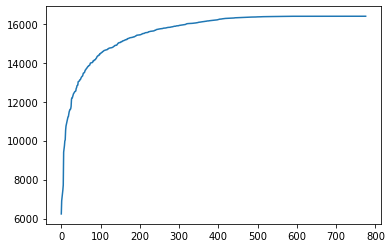

In [86]:
black.sort(key=lambda a: a[1])
colour = [i[1] for i in black]
plt.plot(colour)

[415, 418, 420, 425, 426, 427, 434, 439, 441, 443, 451, 452, 455, 461, 473, 474, 481, 484, 495, 496, 502, 503, 505, 512, 520, 526, 534, 542, 543, 547, 551, 552, 555, 557, 568, 570, 573, 584, 611, 613, 616, 618, 620, 624, 626, 628, 631, 634, 639, 641, 643, 652, 656, 666, 674, 678, 679, 688, 696, 705, 714, 717, 719, 721, 725, 731, 742, 743, 745, 750, 753, 760, 763, 764, 767, 774]


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_73900/1434103138.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure();


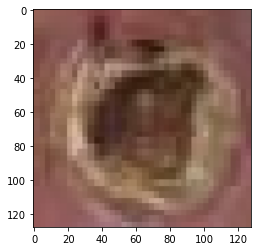

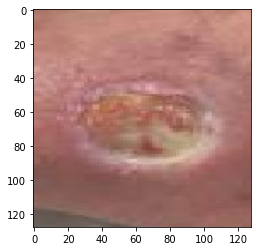

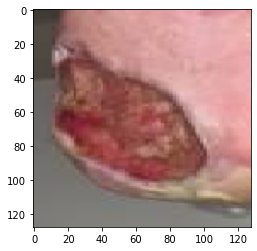

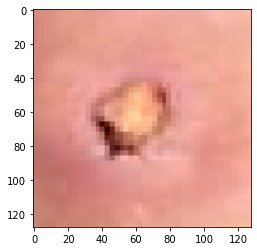

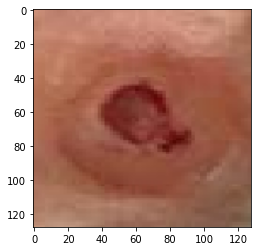

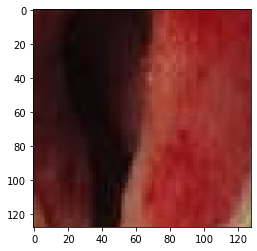

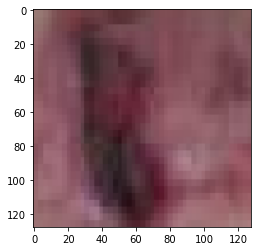

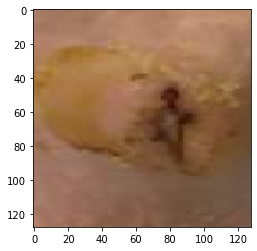

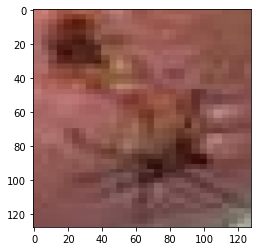

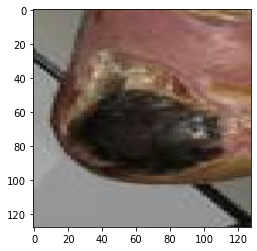

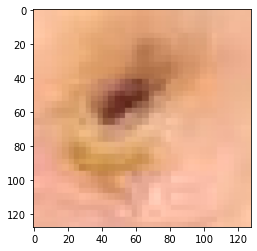

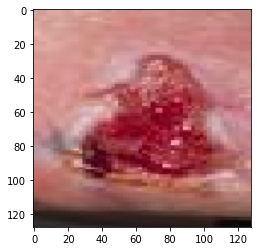

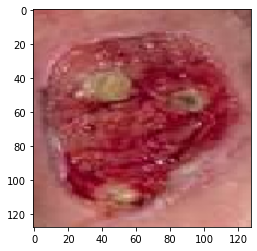

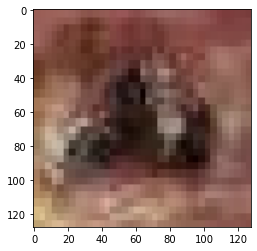

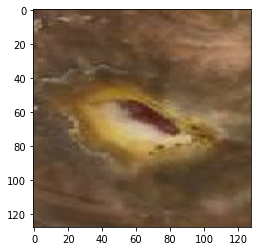

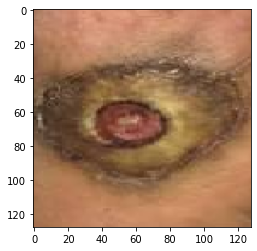

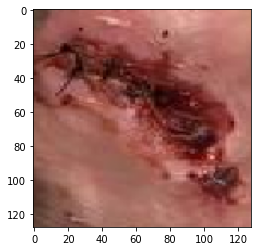

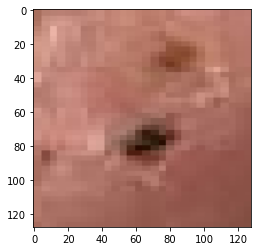

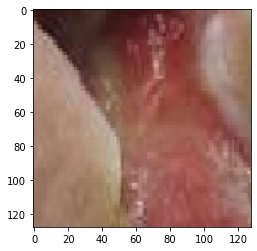

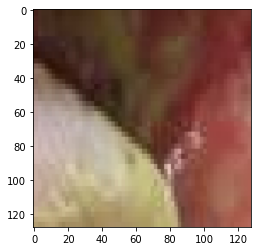

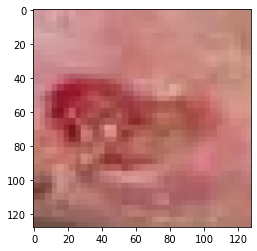

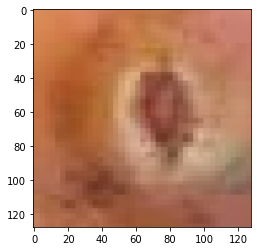

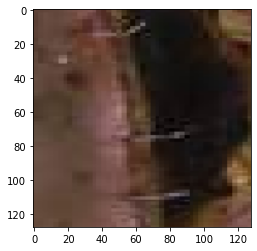

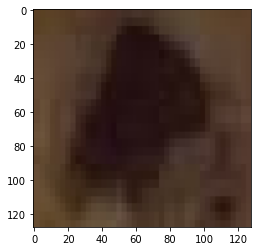

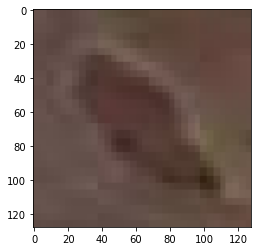

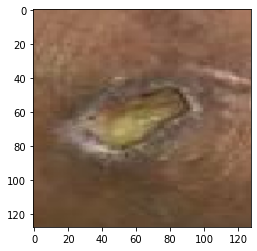

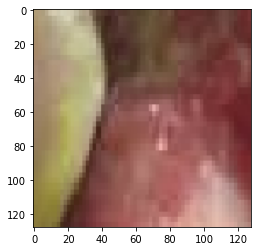

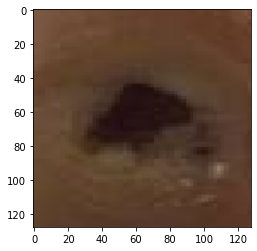

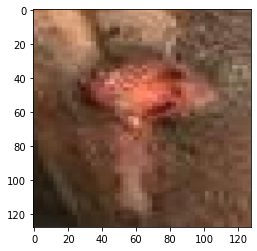

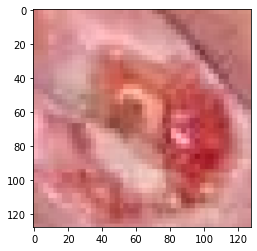

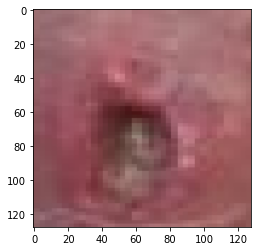

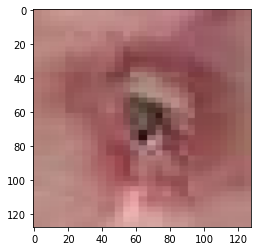

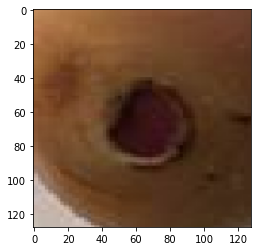

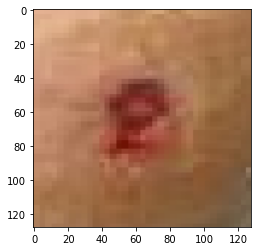

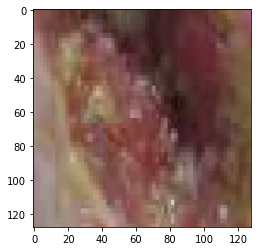

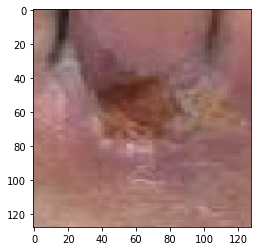

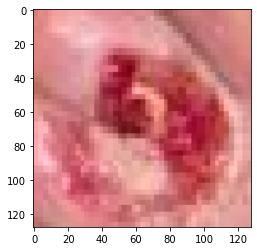

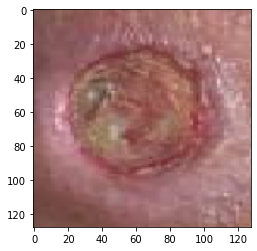

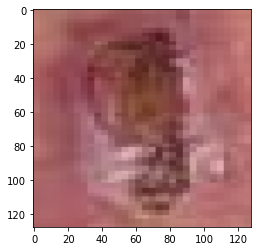

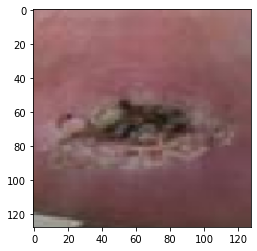

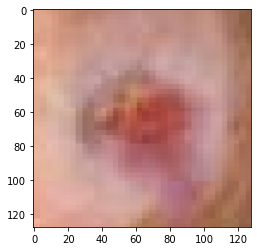

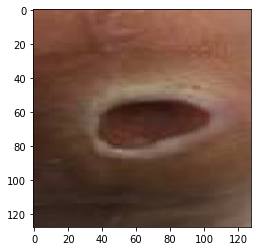

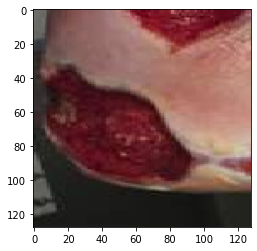

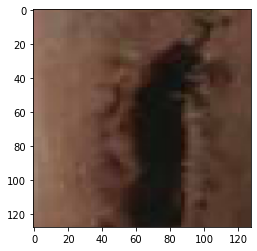

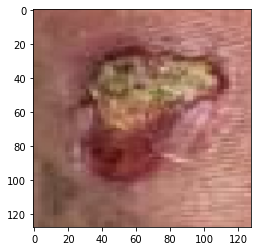

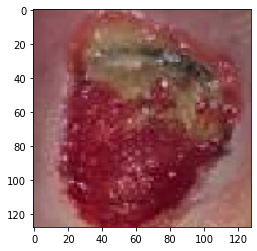

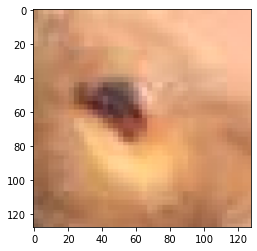

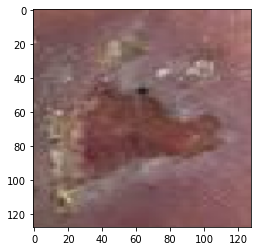

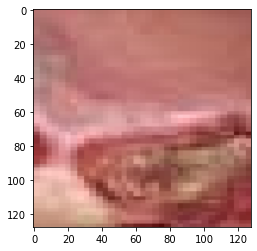

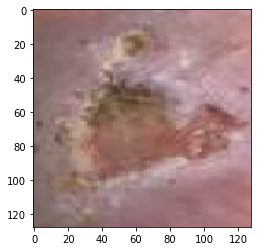

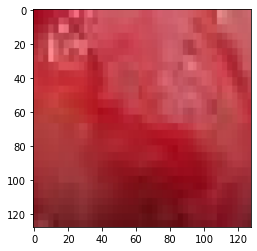

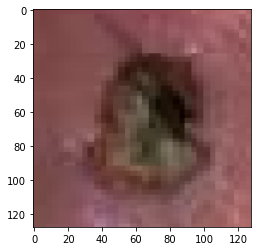

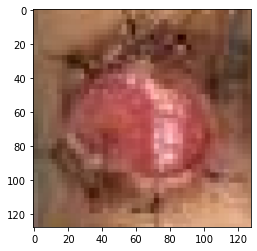

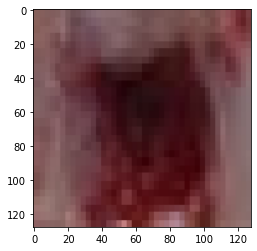

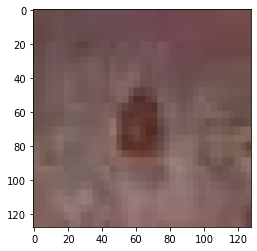

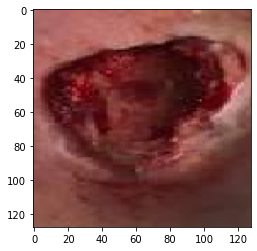

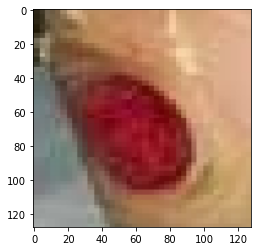

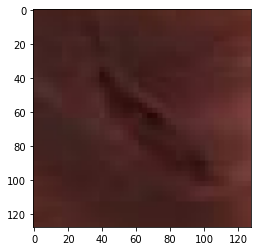

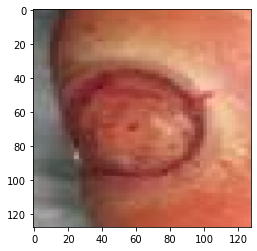

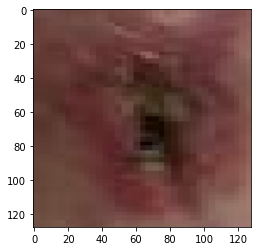

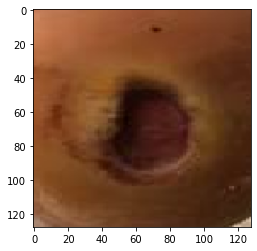

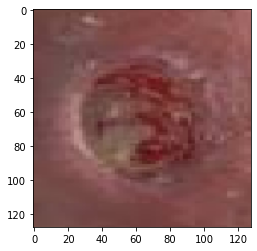

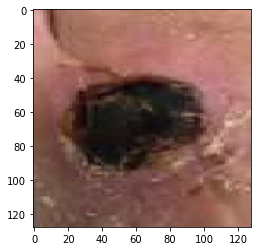

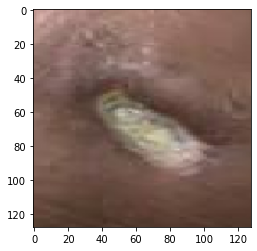

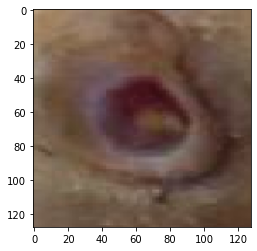

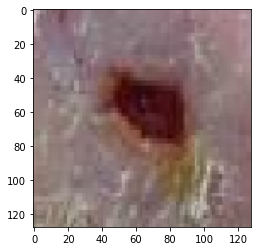

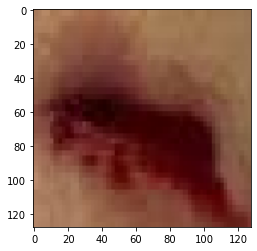

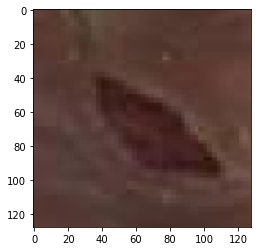

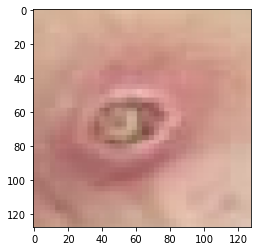

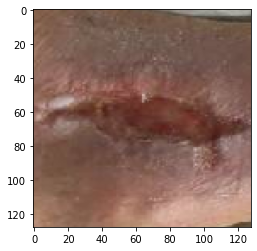

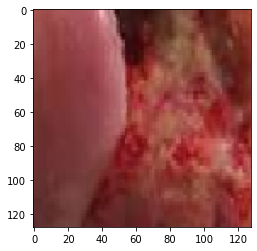

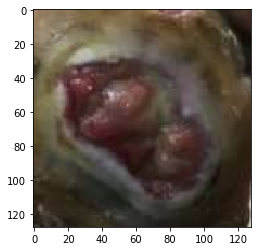

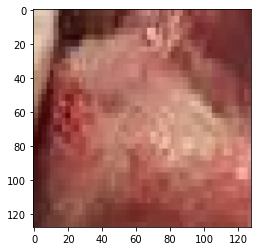

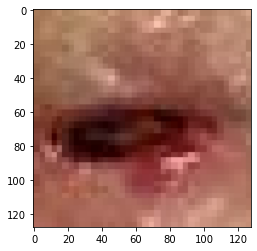

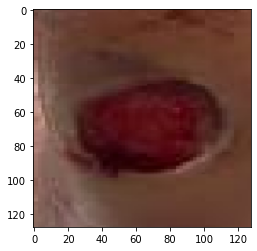

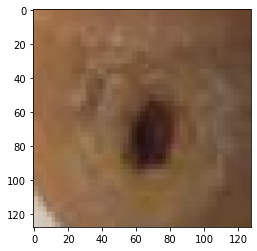

In [92]:
necrosis = black[700:]
necrosis = [i[0] for i in necrosis]
print(necrosis)
for i in necrosis:
    plt.figure();
#     idx = i[1]
    img = cv2.imread(d+names[i])
    plt.imshow(img[:,:,::-1])